In [1]:
!nvidia-smi

Fri Jan  3 20:55:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
#!pip install sentencepiece

In [3]:
import sys
from google.colab import drive
drive.mount('/content/drive/')
root_path = 'drive/My Drive/Colab_Notebooks/deeplearning/Sentence_VAE/'
sys.path.append(root_path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Imports

In [0]:
# import model
from modules.model import RNN_VAE, word_dropout

# import loss functions
from modules.loss_functions import ELBO_loss, ELBO_lAnneal, ELBO_cAnneal, ELBO_cAnnealFB, cycAnneal

# import utils
from modules.utils import print_generative_reconstruction, print_reconstruction, plot_loss, getActiveUnits, print_generative_reconstruction, pad_token_array, get_latent_rep_of_sentence, deterministic_generate_sentence_from_latent, generate_sentence_from_latent

In [0]:
import torch
from torch.utils.data import DataLoader
from torch import optim
import sentencepiece as spm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from IPython.display import Image, display, clear_output
import time

# Load data and model

Small

In [6]:
"""
data_dict = pickle.load( open( root_path + "FR_data_set_sub10.p", "rb" ))
training_data = data_dict["train"]["formal"] + data_dict["train"]["informal"]
test_data = data_dict["test"]["formal"] + data_dict["test"]["informal"]
print("FR part")
print(f"train formal len: {len(data_dict['train']['formal'])}")
print(f"train informal len: {len(data_dict['train']['informal'])}")
print(f"test formal len: {len(data_dict['test']['formal'])}")
print(f"test informal len: {len(data_dict['test']['informal'])}")
print("\nData sizes")
print(f"training data len: {len(training_data)}")
print(f"test data len: {len(test_data)}")
"""

'\ndata_dict = pickle.load( open( root_path + "FR_data_set_sub10.p", "rb" ))\ntraining_data = data_dict["train"]["formal"] + data_dict["train"]["informal"]\ntest_data = data_dict["test"]["formal"] + data_dict["test"]["informal"]\nprint("FR part")\nprint(f"train formal len: {len(data_dict[\'train\'][\'formal\'])}")\nprint(f"train informal len: {len(data_dict[\'train\'][\'informal\'])}")\nprint(f"test formal len: {len(data_dict[\'test\'][\'formal\'])}")\nprint(f"test informal len: {len(data_dict[\'test\'][\'informal\'])}")\nprint("\nData sizes")\nprint(f"training data len: {len(training_data)}")\nprint(f"test data len: {len(test_data)}")\n'

Large

In [7]:
data_dict = pickle.load(open(root_path + "FREM_data_set_sub10.p", "rb"))
training_data = data_dict["FR"]["train"]["formal"] + data_dict["FR"]["train"]["informal"] + data_dict["EM"]["train"]["formal"] + data_dict["EM"]["train"]["informal"]
test_data = data_dict["FR"]["test"]["formal"] + data_dict["FR"]["test"]["informal"] + data_dict["EM"]["test"]["formal"] + data_dict["EM"]["test"]["informal"] 
print("EM part")
print(f"train formal len: {len(data_dict['EM']['train']['formal'])}")
print(f"train informal len: {len(data_dict['EM']['train']['informal'])}")
print(f"test formal len: {len(data_dict['EM']['test']['formal'])}")
print(f"test informal len: {len(data_dict['EM']['test']['informal'])}")
print("\nFR part")
print(f"train formal len: {len(data_dict['FR']['train']['formal'])}")
print(f"train informal len: {len(data_dict['FR']['train']['informal'])}")
print(f"test formal len: {len(data_dict['FR']['test']['formal'])}")
print(f"test informal len: {len(data_dict['FR']['test']['informal'])}")
print("\nData sizes")
print(f"training data len: {len(training_data)}")
print(f"test data len: {len(test_data)}")

EM part
train formal len: 14557
train informal len: 14557
test formal len: 719
test informal len: 719

FR part
train formal len: 13083
train informal len: 13083
test formal len: 606
test informal len: 606

Data sizes
training data len: 55280
test data len: 2650


In [0]:
# Load sentencepiece model (See local notebook for how to create the sentencepiece model)

#small
#sp = spm.SentencePieceProcessor()
#sp.Load(root_path + 'FRtraintest16000.model')
#VOCAB_SIZE = 16000

#large
sp = spm.SentencePieceProcessor()
sp.Load(root_path + 'fulltraintest32000.model')
VOCAB_SIZE = 32000

Small

In [0]:
BATCH_SIZE = 2048
from torch.utils.data import DataLoader

train_data_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_data_loader = DataLoader(test_data, batch_size=len(test_data))



In [10]:
EMBEDDING_DIM = 300
HIDDEN_DIM = 300
LATENT_DIM = 64
SEQ_LEN = 12 #padded + EOS + SOS
WORD_DROPOUT_P = 0.25
rnn_vae =  RNN_VAE(embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM,
                  latent_dim=LATENT_DIM, vocab_size=VOCAB_SIZE, seq_length=SEQ_LEN, word_dropout_p=WORD_DROPOUT_P).cuda()

rnn_vae.load_state_dict(torch.load(root_path + "trained_models/" + "cyc_wd_model_fulldata.pt"))

<All keys matched successfully>

## Results

#### Qualitative results

In [11]:
print_generative_reconstruction(rnn_vae=rnn_vae, sp=sp, sentence_in_batch=0, train_data_loader=train_data_loader)

Real sentence: it might be spelled incorrectly, i apologize.
Generated sentence: it often happens if you have communicated.



In [12]:
for i in range(10):
  print_generative_reconstruction(rnn_vae=rnn_vae, sp=sp, sentence_in_batch=i, train_data_loader=train_data_loader)
  print('*******')

Real sentence: yes, i do love her a lot.
Generated sentence: yes, i am in love with you.

*******
Real sentence: dont make it a racial thing.
Generated sentence: dont go back to a guy already.

*******
Real sentence: talk with her a little everyday.
Generated sentence: slap her with a little faster?

*******
Real sentence: go look in the mirror right now.
Generated sentence: go to the yellow pages of friend.

*******
Real sentence: yes, um no i dont know ask her!
Generated sentence: whta kinda of person would do that.

*******
Real sentence: i think that you could go to the movies.
Generated sentence: i believe that he wants to be your thing...

*******
Real sentence: you two do not have enough differences.
Generated sentence: we did not like to know that.

*******
Real sentence: boy bands should all be illegal!
Generated sentence: all eyes pick is to play!

*******
Real sentence: sure its been done plenty of times.
Generated sentence: now maybe a chainsaw will just laugh.

*******
Rea

# Latent space exploration

In [0]:
def get_latent_representation(token_sentences, rnn_vae):
    """
    Get the latent space embeddings of the given sentences using the rnn_vae model
    :param token_sentences: array of tokenized sentences
    :param rnn_vae: RNN_VAE object
    :return:
    """
    rnn_vae.eval()
    embeds = []
    for sentence in token_sentences:
        z, sigma = rnn_vae.encode(sentence.unsqueeze(0).cuda())
        embeds.append(z.detach().squeeze().cpu().tolist())
    rnn_vae.train()
    return embeds

In [0]:
FR_formal_embeds = get_latent_representation(data_dict["FR"]["train"]["formal"], rnn_vae)
FR_informal_embeds = get_latent_representation(data_dict["FR"]["train"]["informal"], rnn_vae)

EM_formal_embeds = get_latent_representation(data_dict["EM"]["train"]["formal"], rnn_vae)
EM_informal_embeds = get_latent_representation(data_dict["EM"]["train"]["informal"], rnn_vae)

In [0]:
from sklearn.manifold import TSNE
import seaborn as sns

In [0]:
# EM, FR, formal, informal order
plot_subset = FR_formal_embeds[0:2000] + EM_formal_embeds[0:2000] + FR_informal_embeds[0:2000] + EM_informal_embeds[0:2000] 

In [17]:
tsne = TSNE(n_components=2, verbose=1, init='pca', perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(plot_subset)
tsne_df = pd.DataFrame(tsne_results, columns=["x","y"])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.025s...
[t-SNE] Computed neighbors for 8000 samples in 3.585s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 0.461506
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.360390
[t-SNE] KL divergence after 1000 iterations: 1.965086


In [0]:
groups = [x // 2000 for x in range(len(plot_subset))]
tsne_df["group"] = groups
name_dict = {0: "FR formal", 1: "EM formal", 2: "FR informal", 3: "EM informal"}
formality_dict = {0: "formal", 1: "informal"}

In [0]:
tsne_df['data_label'] = tsne_df.apply (lambda row: name_dict[row.group], axis=1)
tsne_df['formality'] = tsne_df.apply (lambda row: formality_dict[row.group // 2], axis=1)

In [0]:
group0 = tsne_df.loc[tsne_df.group == 0][0:200]
group1 = tsne_df.loc[tsne_df.group == 1][0:200]
group2 = tsne_df.loc[tsne_df.group == 2][0:200]
group3 = tsne_df.loc[tsne_df.group == 3][0:200]

In [0]:
frames = [group0, group1, group2, group3]
sub_tsne_df = pd.concat(frames)

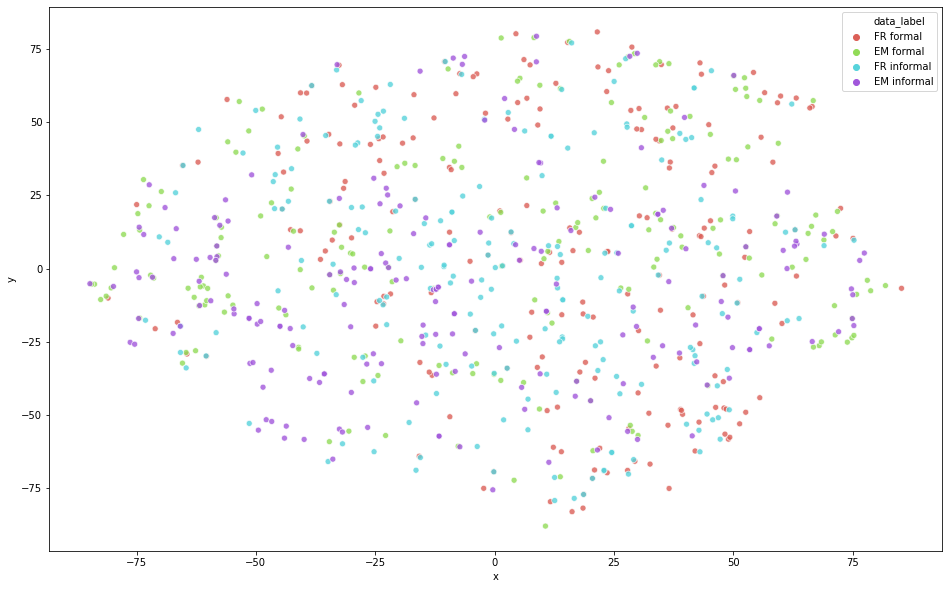

In [22]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="x", y="y",
    hue="data_label",
    palette=sns.color_palette("hls", 4),
    data=sub_tsne_df,
    legend="full",
    alpha=0.8
)

## Formality direction

In [0]:
FR_formal_tsne = tsne_df.loc[tsne_df.data_label == "FR formal"]
FR_informal_tsne = tsne_df.loc[tsne_df.data_label == "FR informal"].reset_index(inplace=False)

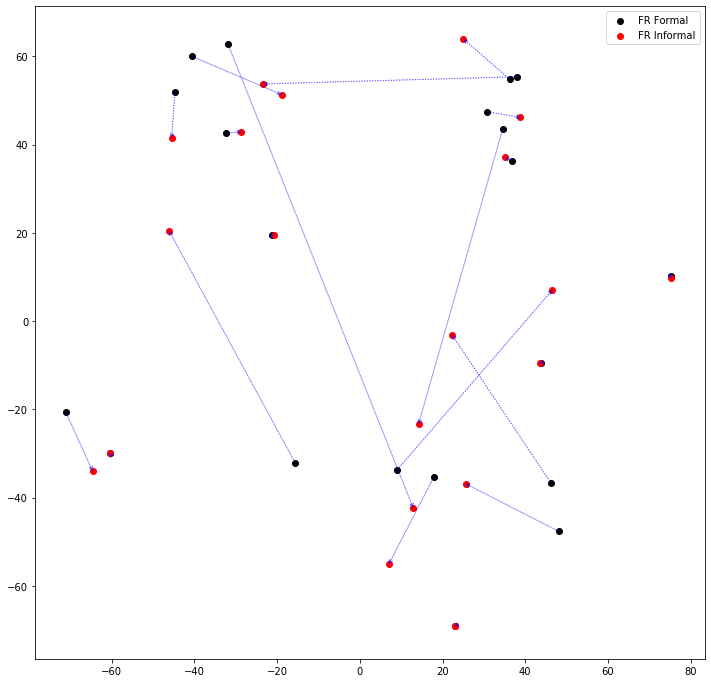

In [24]:
NUM_VECTORS = 20
x_formal = FR_formal_tsne['x'].values[:NUM_VECTORS]
y_formal = FR_formal_tsne['y'].values[:NUM_VECTORS]

x_informal = FR_informal_tsne['x'].values[:NUM_VECTORS]
y_informal = FR_informal_tsne['y'].values[:NUM_VECTORS]

x_direction = x_informal - x_formal
y_direction = y_informal - y_formal

plt.figure(figsize=(12,12))
plt.scatter(x_formal, y_formal, c="black")
plt.scatter(x_informal, y_informal, c="red")

for i in range(NUM_VECTORS):
  plt.arrow(x_formal[i], y_formal[i], x_direction[i], y_direction[i], head_width=1, head_length=1, length_includes_head=True, ls=':', color='blue', alpha=0.5)

plt.legend(['FR Formal', 'FR Informal'])
plt.show()

# Changing formality in latent space

In [25]:
z = get_latent_rep_of_sentence(rnn_vae, sp, "This is not a monkey")
recon_sentence = generate_sentence_from_latent(rnn_vae, sp, z, 12)
recon_sentence

TypeError: ignored

### Continously sampling between sentences

#### Sampling between different sentences

In [0]:
sentence1 = sp.decode_ids(data_dict["FR"]["train"]["formal"][42].tolist())
sentence2 = sp.decode_ids(data_dict["EM"]["train"]["informal"][42].tolist())
print(f"Sentence 1: {sentence1}")
print(f"Sentence 2: {sentence2}")

In [0]:
z_1 = get_latent_rep_of_sentence(rnn_vae, sp, sentence1)
z_2 = get_latent_rep_of_sentence(rnn_vae, sp, sentence2)

for i in range(1,11):
  k = i/10
  traversing_z = z_2 * k + (1 - k) * z_1
  recon = deterministic_generate_sentence_from_latent(rnn_vae, sp, traversing_z, 12)
  print(f"{1-k:.2f} * sentence 1 + {k:.2f} * sentence 2 = {recon}")


#### Sampling between formalities

In [0]:
# 700
sentence_num = 700
sentence1 = sp.decode_ids(data_dict["EM"]["train"]["formal"][sentence_num].tolist())
sentence2 = sp.decode_ids(data_dict["EM"]["train"]["informal"][sentence_num].tolist())
print(f"Sentence 1: {sentence1}")
print(f"Sentence 2: {sentence2}")

In [0]:
z_1 = get_latent_rep_of_sentence(rnn_vae, sp, sentence1)
z_2 = get_latent_rep_of_sentence(rnn_vae, sp, sentence2)

for i in range(0,11):
  k = i/10
  traversing_z = z_2 * k + (1 - k) * z_1
  recon = deterministic_generate_sentence_from_latent(rnn_vae, sp, traversing_z, 12)
  print(f"{1-k:.2f} * sentence 1 + {k:.2f} * sentence 2 = {recon}")


### Adding mean formality

In [0]:
formal_embeds = np.array(FR_formal_embeds + EM_formal_embeds)
informal_embeds = np.array(FR_informal_embeds + EM_informal_embeds)
dirs = informal_embeds - formal_embeds
mean_dir = np.mean(dirs, axis=0).tolist()

In [0]:
test_sentence = sp.decode_ids(data_dict["EM"]["train"]["formal"][700].tolist())
target_sentence = sp.decode_ids(data_dict["EM"]["train"]["informal"][700].tolist())
print(f"test sentence: {test_sentence}")
print(f"target sentence: {target_sentence}")

In [0]:
start_z = get_latent_rep_of_sentence(rnn_vae, sp, test_sentence)
moved_z = start_z + torch.tensor(mean_dir).cuda()
unmoved_recon = deterministic_generate_sentence_from_latent(rnn_vae, sp, start_z, 12)
recon = deterministic_generate_sentence_from_latent(rnn_vae, sp, moved_z, 12)
print(f"unmoved recon: {unmoved_recon}")
print(f"moved recon: {recon}")